<div style="font-weight: bold; color:#5D8AA8" align="center">
    <div style="font-size: xx-large">Métodos Funcionales en Aprendizaje Automático</div><br>
    <div style="font-size: x-large; color:gray">Examen 02 - Manifold Learning</div><br>
    <div style="font-size: large; color:#FF0000">Nombre del autor</div><br></div><hr>
</div>

**Configuración Inicial**

In [1]:
%%html
<style>
    .qst {background-color: #b1cee3; padding:10px; border-radius: 5px; border: solid 2px #5D8AA8;}
    .qst:before {font-weight: bold; content:"Pregunta"; display: block; margin: 0px 10px 10px 10px;}
    h1, h2, h3 {color: #5D8AA8;}
    .text_cell_render p {text-align: justify; text-justify: inter-word;}
</style>

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [29]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors

from mpl_toolkits.mplot3d import Axes3D

# My imports
import utils
from typing import Callable, Optional, Union, Type
from sklearn.utils.extmath import svd_flip
from sklearn.gaussian_process.kernels import RBF as rbf_kernel
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import laplacian_kernel
from sklearn.datasets import make_s_curve
from sklearn.neighbors import NearestNeighbors

# Import and initialize scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

matplotlib.rc('figure', figsize=(15, 5))

my_cmap = plt.cm.Spectral
seed = 1234

# Directrices generales

Este notebook contiene el enunciado de la segunda parte del examen de *Métodos Funcionales en Aprendizaje Automático*.

Por favor, lee con cuidado cada uno de los tres ejercicios así como las preguntas que en ellos se formulan, y explica de manera concisa cada asunción y conclusión que hagas.

Debéis entregar un **informe** (que puede realizarse directamente sobre el notebook) y el **código** implementado para completar los ejercicios, así como las **referencias** consultadas en caso de necesidad. También se debe entregar el **código de honor firmado**. Todo esto se enviará vía Moodle en un *.zip*.

# Ejercicio 1 (3 puntos)

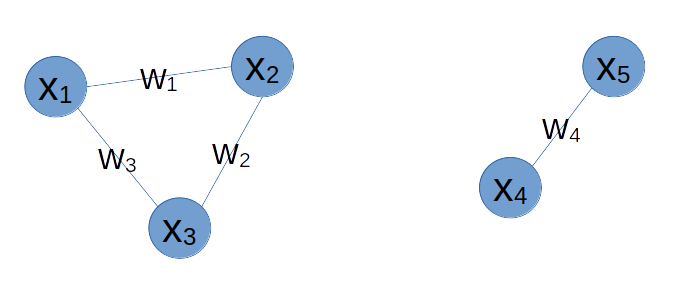

<div class="qst">

* Para el grafo anterior, calcula $f^\top L f$, siendo $L$ el laplaciano del grafo no normalizado ($L = D- W$) cuando $f$ se define como:
    $f(x_1) = 1, f(x_2) = 2, f(x_3) = 6, f(x_4) = 5, f(x_5) = 4$
  si los pesos del grafo son:
    $w_1 = 20, w_2 = 10, w_3 = 1, w_4 = 5$.
</div>

***Solución.-***

Asumimos que el peso de los lazos (lados conectado un nodo consigo mismo) es `0`, al no aparecer ningún peso en la imagen anterior. Definimos la matriz $W$ y computamos el laplaciano del grafo:

In [4]:
def evaluate_laplacian(W, f):
    # Compute diagonal matrix
    D = np.diag(np.sum(W, axis=1))
    
    # Compute laplacian
    L = D - W
    
    # Evaluate and also return the laplacian
    return L, f @ L @ f.T

W = np.array([
    [0, 20, 1, 0, 0],
    [20, 0, 10, 0, 0],
    [1, 10, 0, 0, 0],
    [0, 0, 0, 0, 5],
    [0, 0, 0, 5, 0]
], dtype=float)

f = np.array([1, 2, 6, 5, 4], dtype=float)

L, result = evaluate_laplacian(W, f)
print('L: {} \n'.format(L))
print('f^T L f: {}'.format(result))

L: [[ 21. -20.  -1.   0.   0.]
 [-20.  30. -10.   0.   0.]
 [ -1. -10.  11.   0.   0.]
 [  0.   0.   0.   5.  -5.]
 [  0.   0.   0.  -5.   5.]] 

f^T L f: 210.0


<div class="qst">

* Calcula $f^\top L f$ si cambiamos el valor de los pesos $w_1=1$ y $w_3=20$. ¿Cambia el resultado? ¿Por qué? 

</div>

***Solución.-***

In [5]:
W = np.array([
    [0, 1, 20, 0, 0],
    [1, 0, 10, 0, 0],
    [20, 10, 0, 0, 0],
    [0, 0, 0, 0, 5],
    [0, 0, 0, 5, 0]
], dtype=float)

L, result = evaluate_laplacian(W, f)
print('L: {} \n'.format(L))
print('f^T L f: {}'.format(result))

L: [[ 21.  -1. -20.   0.   0.]
 [ -1.  11. -10.   0.   0.]
 [-20. -10.  30.   0.   0.]
 [  0.   0.   0.   5.  -5.]
 [  0.   0.   0.  -5.   5.]] 

f^T L f: 666.0


Como podemos ver, el resultado ha cambiado de `210` a `666`. Para responder a por qué ocurre este hecho hemos de dar contexto a las operaciones que estamos realizando. En el contexto de los *Laplacian Eigenmaps*, se crea un grafo para un conjunto de datos con pesos asociados a la afinidad de los nodos. Es decir, cuanto más cerca estén dos muestras $x_i, x_j$, mayor será el peso asociado entre las mismas, $w_{ij}$.

En las notas de clase definimos el **error de reconstrucción**:

$$
    \mathcal J(y) = \frac{1}{2} \sum_{i,j}(y_i - y_j)^2 w_{ij}.
$$

Para minimizar errores hemos de asignar valores de $y_i$ parecidos a elementos con altos pesos (es decir, si los puntos son cercanos, asignamos valores de la función parecidos para que la reconstrucción tenga sentido). También demostramos en clase que el error de reconstrucción coincide con la evaluación de la siguiente forma cuadrática:

$$
    \mathcal J(y) = y^T L y.
$$

En nuestro caso particular, los valores de $f(x_1)$ y $f(x_2)$ son parecidos (`1` y `2` respectivamente), mientras que el valor de $f(x_3) = 6$ dista más de ellos. Por lo tanto, para minimizar el error de reconstrucción, los pesos han de cumplir $w_{1,2} \gg w_{2,3} > w_{1,3}$.

Inicialmente: $w_{1,2} = 20, w_{1,3} = 1$, lo que tiene sentido (los nodos `1` y `2` estarán muy cerca mientras que los nodos `1` y `3` estarán muy lejos). En el segundo caso $w_{1,2} = 1, w_{1,3} = 20$, representando a los nodos `1` y `2` muy lejanos y los nodos `1` y `3` muy cercanos, lo que no encaja para nada con los valores de $f(x)$. Es por ello que el valor de $f^T L f$ (el error de reconstrucción) aumenta considerablemente. 

<div class="qst">

* Define una función $f$ que minimice $f^\top L f$. ¿Existe más de una solución que minimice $f^\top L f$ , sin tener en cuenta múltiplos de la $f$ definida (de manera más formal, que sea linealmente independiente a la solución dada)? 

</div>

***Solución.-***

Nota inicial: Realizaremos la minimización para ambas matrices $W$ definidas en los apartados anteriores. La solución obtenida es válida considerando cualquiera de las dos matrices anteriores.

Sabemos que el laplaciano del grafo no normalizado ($L = D - W$) es una matriz semidefinida positiva. Esto es, $x^T L x \ge 0$ para todo vector $x$. El vector $f_1 = 0$ obtiene como resultado $f_1^T L f_1 = 0$, minimizando la función.

In [6]:
f_1 = np.zeros(5)

_, result = evaluate_laplacian(W, f_1)
print('f^T L f: {}'.format(result))

f^T L f: 0.0


Este mínimo es único salvo múltiplos del mismo. Puesto que nuestra función $g(x) = x^T L x$ es una forma cuadrática, sabemos que es analítica (en particular dos veces derivable), y que una función dos veces derivable es convexa si y sólo si su matriz Hessiana ($L$, por ser una forma cuadrática) es semidefinida positiva, y es estrictamente convexa si y sólo si $L$ es definida positiva.

Si $f$ fuese estrictamente convexa, tendríamos un único mínimo. Sin embargo, sabemos que $\lambda_0 = 0$ siempre es valor propio de $L$, como vimos en clase. En nuestro caso particular:

In [7]:
np.linalg.svd(L)[1]

array([4.74620776e+01, 1.45379224e+01, 1.00000000e+01, 1.17995953e-15,
       0.00000000e+00])

Al tener un valor propio $0$ sabemos que $L$ es semidefinida positiva, luego $g$ no es estrictamente convexa y puede tener otro valor mínimo. Para buscarlo intentamos en primer lugar vectores con valores no nulos en una única posición, pero esto nos devuelve valores de la diagonal multiplicados por un número positivo, por lo que nunca obtendremos un cero.

Hemos de hacer uso de los valores negativos, no situados en la diagonal. Mirando la submatriz inferior derecha de $L$ vemos que si utilizamos el vector $f_2 = (0, 0, 0, 1, 1)$ obtendremos un valor nulo, ya las dos últimas filas (y por tanto las dos últimas columnas) suman `0` cada una:

In [8]:
f_2 = np.array([0, 0, 0, 1, 1])

_, result = evaluate_laplacian(W, f_2)
print('f^T L f: {}'.format(result))

f^T L f: 0.0


Sin embargo, con esto no basta para asegurar que existan soluciones linealmente independientes, pues $f_1$ y $f_2$ son linealmente dependientes: $f_1 = 0 \cdot f_2$. Mirando la submatriz superior izquierda del laplaciano sin normalizar con la idea anterior en mente vemos que la suma de las tres primeras filas (así como la de las tres primeras columnas) es nula, por lo que también nos sirve la solución $f_3 = (1, 1, 1, 0, 0)$:

In [9]:
f_3 = np.array([1, 1, 1, 0, 0])

_, result = evaluate_laplacian(W, f_3)
print('f^T L f: {}'.format(result))

f^T L f: 0.0


Con esto hemos encontrado dos mínimos de $g$ linealmente independientes: $f_2$ y $f_3$.

# Ejercicio 2 (4 puntos)

Un algoritmo muy utilizado tanto en el ámbito de manifold learning, como en clustering o en análisis de grafos (por ejemplo para detectar comunidades) es el método de **Spectral Clustering**.
Durante las clases del curso no nos ha dado tiempo a profundizar en él, por lo que vamos a utilizarlo para resolver un problema.

<div class="qst">

* Define una clase **Spectral Clustering**, así como sus funciones fit y fit-transform (no vamos a permitir en este caso la aplicación del método a puntos nuevos fuera de la muestra inicial).
     
* El algoritmo de Spectral Clustering a implementar será el basado en el laplaciano de camino aleatorio, es decir, $L_{rw}=I − D^{−1}W$.
</div>

In [52]:
from sklearn.base import BaseEstimator, TransformerMixin

class SC(TransformerMixin, BaseEstimator):
    """
        Spectral clustering.
    """

    def __init__(self,
                 n_components: int=2,
                 affinity: str='auto',
                 k_nn: int=10,
                 kernel: Union[str, Callable[[
                     np.ndarray, np.ndarray], np.ndarray]] = 'rbf',
                 sigma: Union[str, float] = 'percentile',
                 percentile: float=0.5):
        """
        Initializes the Spectral clustering object
         ----------
        kernel : kernel function to compute affinity matrix. 
                Can be 'rbf', 'laplacian' or a callable
        sigma : Sigma to apply to the kernel
        n_components: number of components to keep after projection
        percentile: percentile (0 to 100) used to compute sigma if needed

        Returns
        -------
        self : returns an instance of self.
        """
        # Assignment of the hyper-parameters
        self.n_components = n_components
        self.affinity = affinity
        self._kernel = kernel
        self.sigma = sigma
        self.percentile = percentile
        self.k_nn = k_nn
        
        # Raise variables
        self._fitted = False
        self._fixed_sigma = False

    def _determine_sigma(self):
        """
        Converts string sigma values to actual float sigma values
        """
        if self.sigma == 'median':
            self.sigma = np.percentile(pairwise_distances(self.X), 50)
        elif self.sigma == 'maximum':
            self.sigma = np.percentile(pairwise_distances(self.X), 100)
        elif self.sigma == 'percentile':
            self.sigma = np.percentile(
                pairwise_distances(self.X), self.percentile)
        self._fixed_sigma = True

    def _determine_kernel(self):
        """
        Converts kernel value to final kernel
        """
        if not self._fixed_sigma:
            raise ValueError("Sigma has not been fixed yet")

        if self._kernel in ['auto', 'rbf']:
            # Recall that this rbf_kernel is the one from
            # Gaussian procesess, which receives sigma as parameter
            self._kernel = rbf_kernel(self.sigma)

        elif self._kernel == 'laplacian':
            self._kernel = lambda X, y = None: laplacian_kernel(
                X, y, gamma=1/(2*self.sigma**2))

    def _compute_weights_matrix(self):
        if self.affinity in ['auto', 'kernel']:
            # Determine sigma and kernel
            self._determine_sigma()
            self._determine_kernel()

            # Instantiate the kernel and compute the affinity matrix.
            # This will be our weights matrix
            return self._kernel(self.X, self.X)

        elif self.affinity == 'knn':
            nn = NearestNeighbors(n_neighbors=self.k_nn).fit(self.X)
            return nn.kneighbors_graph(self.X).toarray()

        else:
            raise ValueError('affinity parameter must be one of the following: ' + \
                             '\t [auto, kernel, knn]')
            
    def _compute_laplacian(self, W):
        # Compute diagonal matrix
        D = np.diag(np.sum(W, axis=1))
        n = D.shape[0]
        
        self.D = D
        
        # Manually invert only the diagonal, this is O(n)
        # although it is not vectorized (every vectorized
        # approach would take at least O(n^2))
        for i in range(n):
            D[i,i] = 1.0 / D[i,i]

        # Compute the Laplacian following the random walk
        # or left normalization method.
        return np.identity(n) - D @ W

    def fit(self, X, y=None):
        """
        Compute the embedding vectors for data X
        Parameters
        ----------
        X : array-like of shape [n_samples, n_features]
            training set.
        y : Ignored
        Returns
        -------
        self : returns an instance of self.
        """        
        # Save data
        self.X = X

        # Compute the weights matrix
        W = self._compute_weights_matrix()
        
        # Compute the laplacian
        L = self._compute_laplacian(W)
        
        # Since the Laplacian is already symmetric (D and W are so),
        # we may directly compute its SVD decomposition.
        # Remember that eigenvecs has the eigen-vectors as its columns!
        eigenvecs, eigenvals, V = np.linalg.svd(L, full_matrices=True)

        # Make the eigenvector signs match the ones obtained from Sklearn
        eigenvecs, _ = svd_flip(eigenvecs, V)

        # Remove first component, with eigenvalue 1
        # Recall that we are assuming that the eigenvals/vecs are sorted,
        # they are given as such by the np.linalg.svd
        # n_components + 1 since we are already not considering 1st position
        self.eigenvecs = eigenvecs[:, 1:self.n_components + 1]
        self.eigenvals = eigenvals[1:self.n_components + 1]
        
        # Update fitted state
        self._fitted = True
        return self

    def fit_transform(self, X, y=None):
        """Compute the embedding vectors for data X and transform X.
        Parameters
        ----------
        X : array-like of shape [n_samples, n_features]
            training set.
        y : Ignored
        Returns
        -------
        X_red : array-like, shape (n_samples, n_components)
        """
        self.fit(X)
        return self.D @ self.eigenvecs

<div class="qst">

* ¿Qué diferencias aprecias entre este algoritmo y *Diffusion Maps*?
    
</div>

<div class="qst">

* Aplica el algoritmo definido al siguiente conjunto de datos.

    * ¿Se obtiene un buen resultado?

    * ¿Cómo has realizado la selección de hiperparámetros involucrados?
    
</div>

In [53]:
data = np.loadtxt('input/data.txt')
X = data[:,:-1]
y = data[:,-1]

# Preparamos las etiquetas
y[y != 1] = -1

# Scale data
#X = scaler.fit_transform(X)

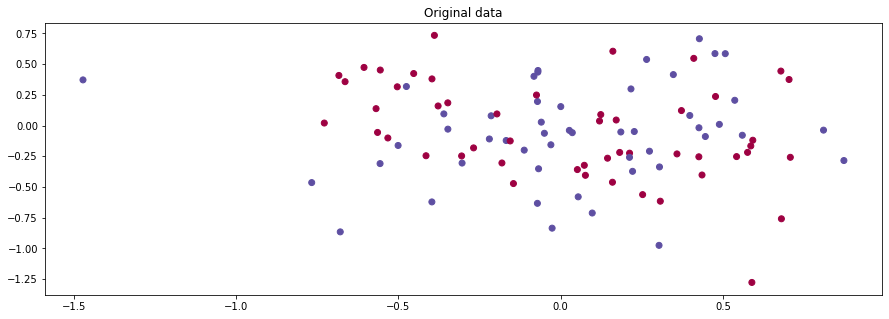

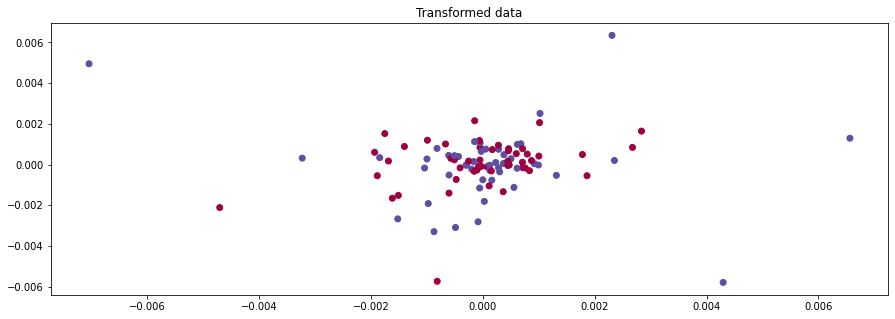

In [54]:
sc = SC(
    n_components = 2,
    affinity = 'kernel',
    kernel = 'rbf',
    sigma = 'median'
)

X_transformed = sc.fit_transform(X)

utils.scatter_2D(X, y, title='Original data')
utils.scatter_2D(X_transformed, y, title='Transformed data')

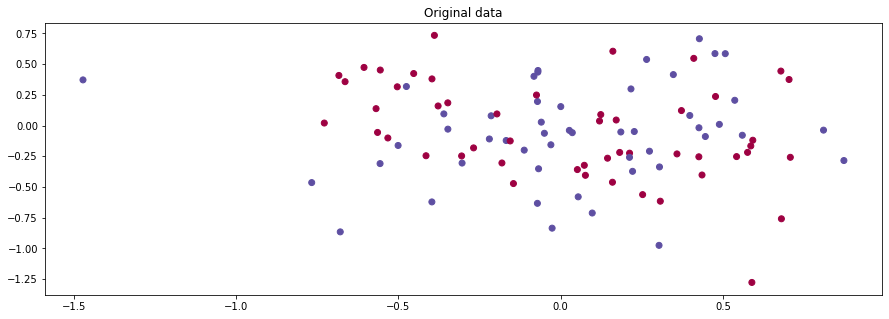

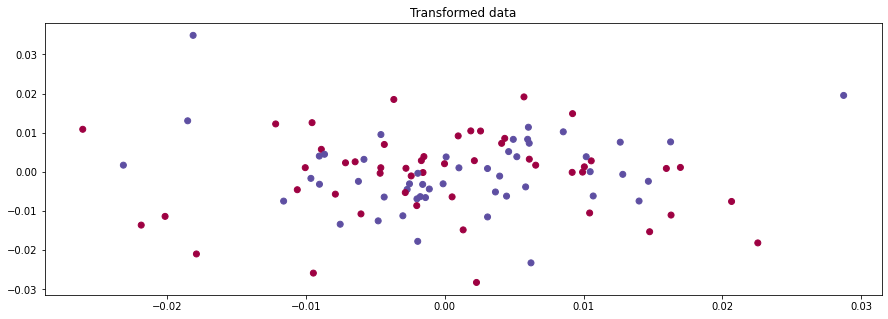

In [55]:
sc = SC(
    n_components = 2,
    affinity = 'knn',
    k_nn = 10,
)

X_transformed = sc.fit_transform(X)

utils.scatter_2D(X, y, title='Original data')
utils.scatter_2D(X_transformed, y, title='Transformed data')

In [37]:
X_transformed.shape

(100, 2)

#### Swiss roll

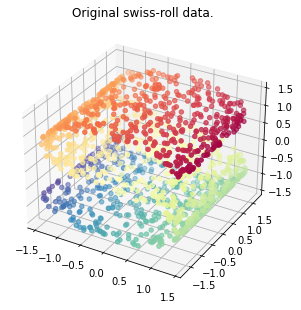

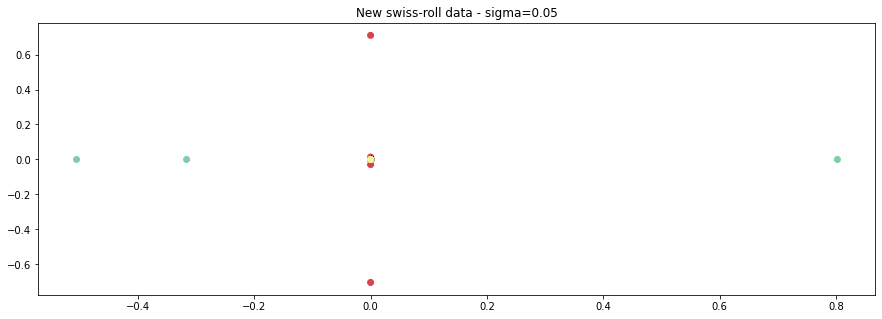

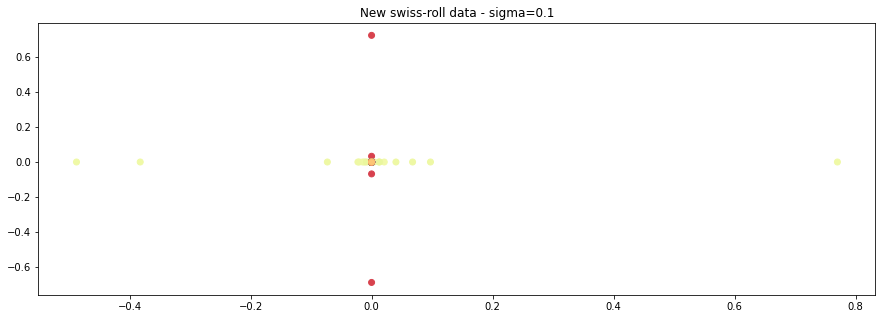

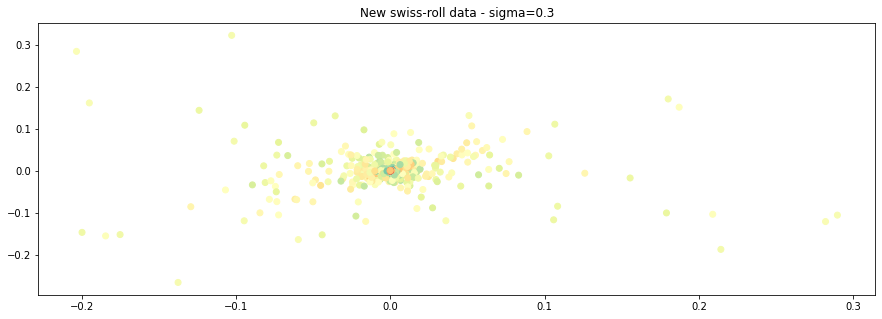

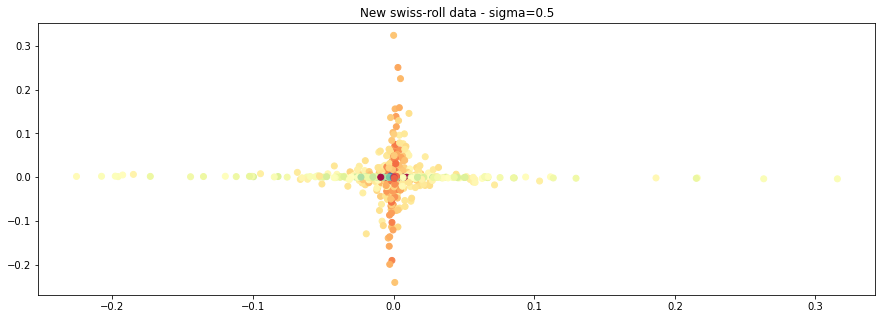

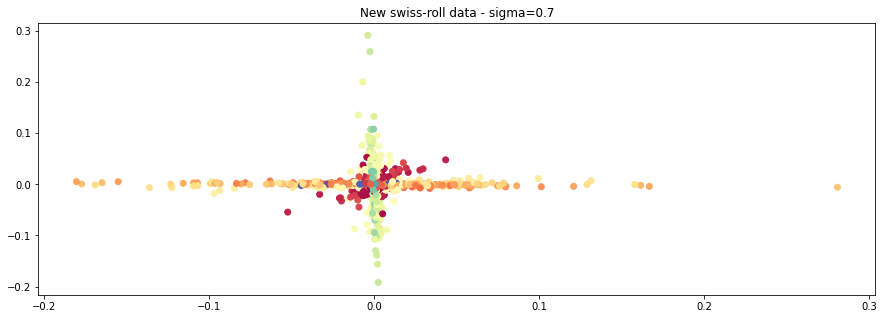

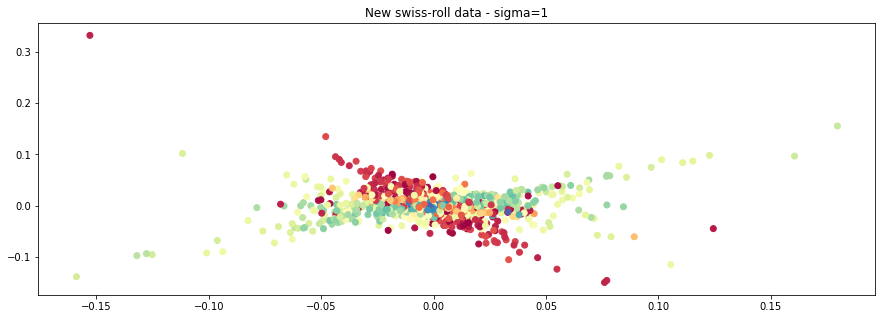

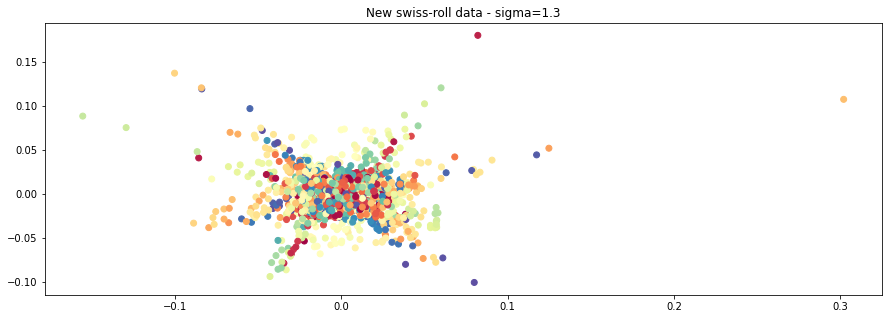

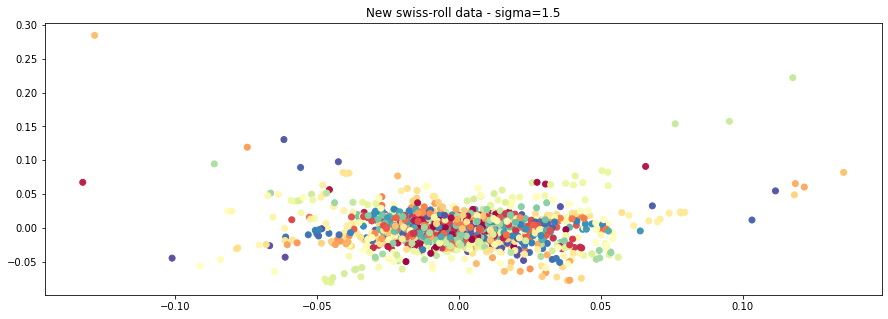

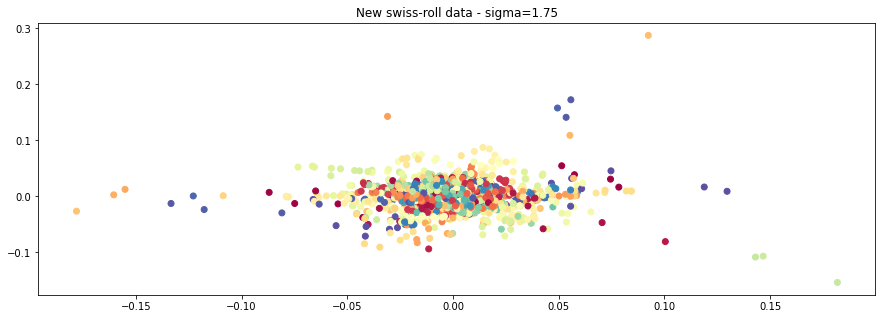

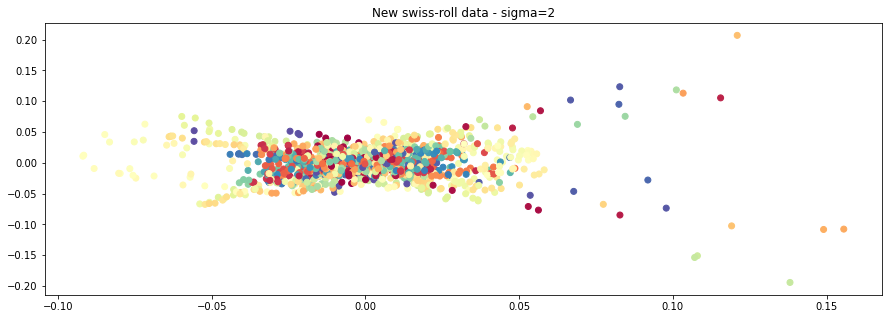

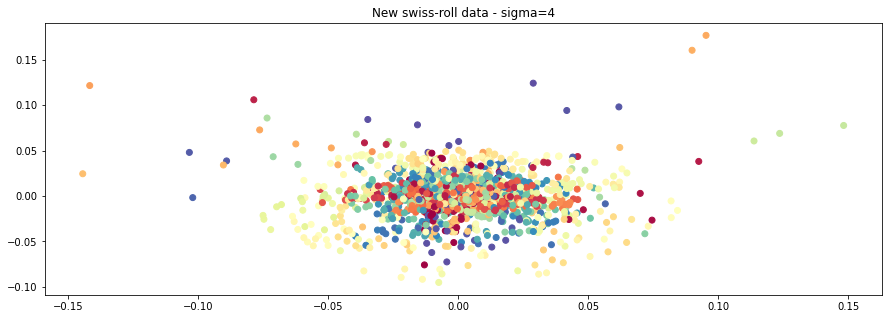

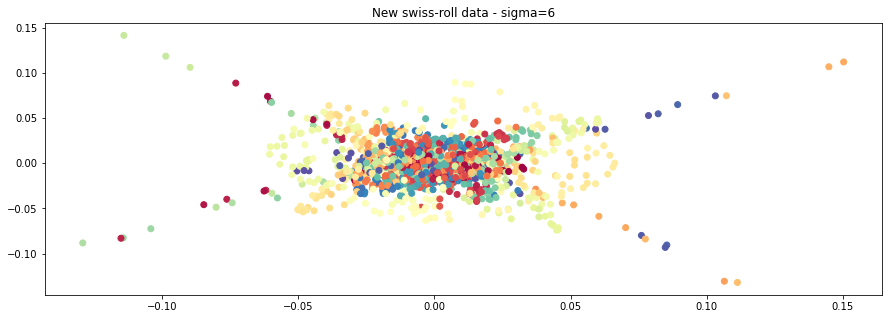

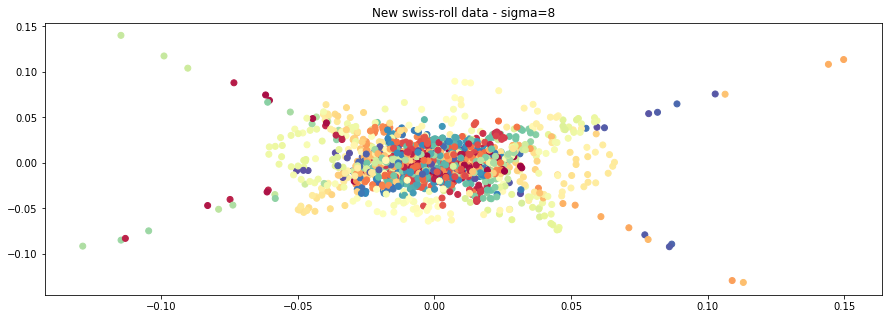

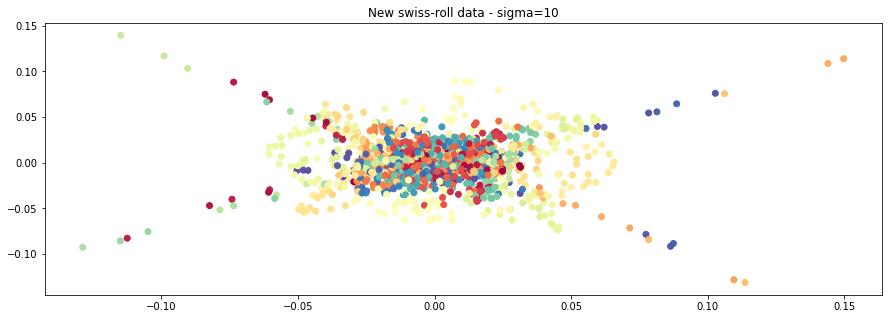

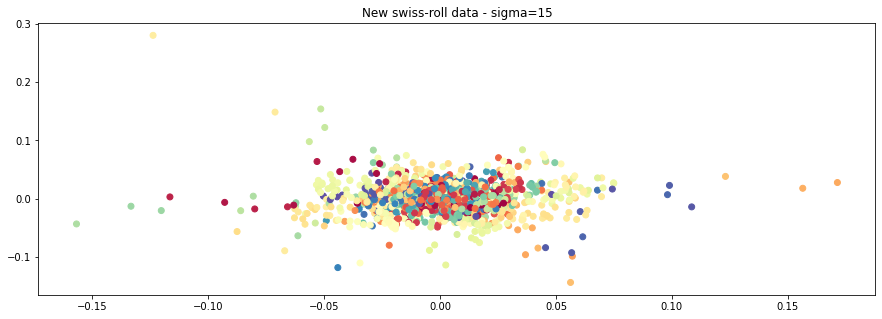

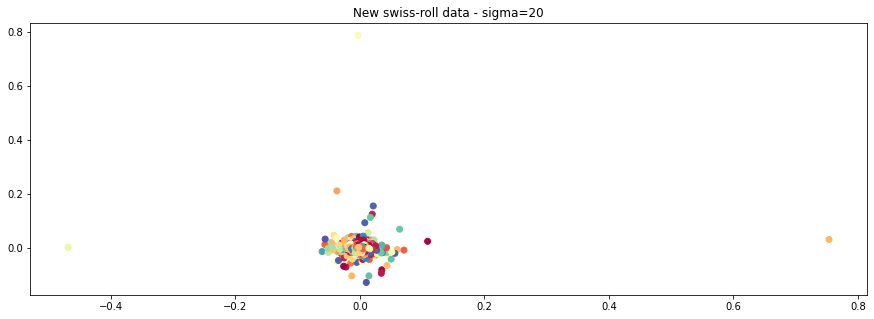

In [38]:
# Create Swiss Roll data
N = 1500
X, color = make_s_curve(n_samples=N, random_state=seed)
X = scaler.fit_transform(X)

utils.scatter_3D(X, color, title="Original swiss-roll data.")

for sigma in [0.05, 0.1, 0.3, 0.5, 0.7, 1, 1.3, 1.5, 1.75, 2, 4, 6, 8, 10, 15, 20]:
    # Initialize Spectral clustering and use it
    sc = SC(
        n_components = 2,
        kernel = 'rbf',
        sigma = sigma,
    )

    X_transformed = sc.fit_transform(X)
    utils.scatter_2D(X_transformed, color, title="New swiss-roll data - sigma={}".format(sigma))

# Ejercicio 3 (3 puntos)

Hasta ahora hemos visto cómo trabajar con una matriz de datos que transformamos en un grafo para aplicar un método de reducción de dimensión espectral, pero todos los algoritmos que hemos vistos podrían aplicarse directamente a un *grafo* con cierta información. Para este ejercicio vamos a trabajar con el grafo del *club de karate de Zacarías* (un ejemplo clásico en teoría de grafos).

Para leer los datos necesitaréis instalar la librería *igraph* y *cairo*, para lo que podéis usar los comandos:<code>
    pip install python-igraph
    pip install pycairo
</code>
Y si os da error porque faltan librerías deberéis instalar:
<code>
    sudo apt install libcairo2-dev
    sudo apt install python3-dev
</code>

Veamos primero que pinta tienen los datos:

In [16]:
from igraph import *

g=Graph.Read_GML("input/karate.gml")
summary(g)

# Información de una arista    
print(g.es[0])
# Acceso a la información del primer nodo del grafo
print(g.vs[g.es[0].tuple[0]])
# Acceso a la información del segundo nodo del grafo
print(g.vs[g.es[0].tuple[1]])

IGRAPH U--- 34 78 -- 
+ attr: id (v)
igraph.Edge(<igraph.Graph object at 0x000001ABCC735138>, 0, {})
igraph.Vertex(<igraph.Graph object at 0x000001ABCC735138>, 0, {'id': 1.0})
igraph.Vertex(<igraph.Graph object at 0x000001ABCC735138>, 1, {'id': 2.0})


El siguiente código permite visualizar el grafo dado.
En este caso permitimos que se seleccione de manera automática el mejor algoritmo de visualización, etiquetamos los nodos por su identificador y lo coloreamos (todo del mismo color pues a priori no conocemos las comunidades).

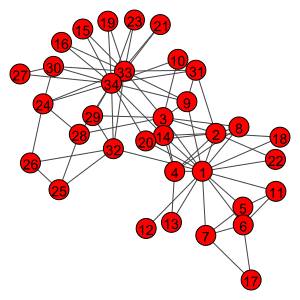

In [17]:
layout = g.layout("auto")
g.vs["label"] = [int(idx) for idx in g.vs["id"]]
plot(g, layout=layout, bbox=(0, 0, 300, 300))

<div class="qst">

* Obten la matriz de pesos del grafo a partir de los datos dados usando la librería igraph proporcionada.

</div>

<div class="qst">

* Aplica el algoritmo de Spectral Clustering de manera que se observen lo mejor posible las dos comunidades existentes en el grafo.

</div>